# Aug 28 data electrode A

1e-7 M CuT, 0.01 M KNO3 electrolyte, pH 8

electrode A is the original electrode (old one)


In [1]:
% setup environment
% set path to equilibrium solver
txt=pwd;
n=length(txt);
rootpath=txt; %txt(1:n-8);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB']; addpath(JEQUILIBpath);
Cumodelspath=[rootpath,'/Cutableaus']; addpath(Cumodelspath);
% clear data and number format
clear; format short e
% turn off warnings
warning off
graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 

In [2]:
% put in constants
VT=0.05; %total volume
stockCuconc=0.0152067;

In [3]:
% put in data
data=[...
%volCu mV pH
0 88 2.001
50 107 2.001
100 115.9 1.987
250 125.8 1.99
500 136.6 1.994
1000 146.7 2.002
];

originalsamplemVnpH=[...
%pH mV
8.045  76.2
8.059  76.9
];

pH = 8.0520e+00


logCuonept = -7.3868e+00


logCuoneptmeasuredslope = -7.3758e+00


logCufullcalib = -7.3731e+00


logCulinearcalib = -5.7959e+00


logCulowslopecalib = -8.3164e+00


err = 3.1541e+00


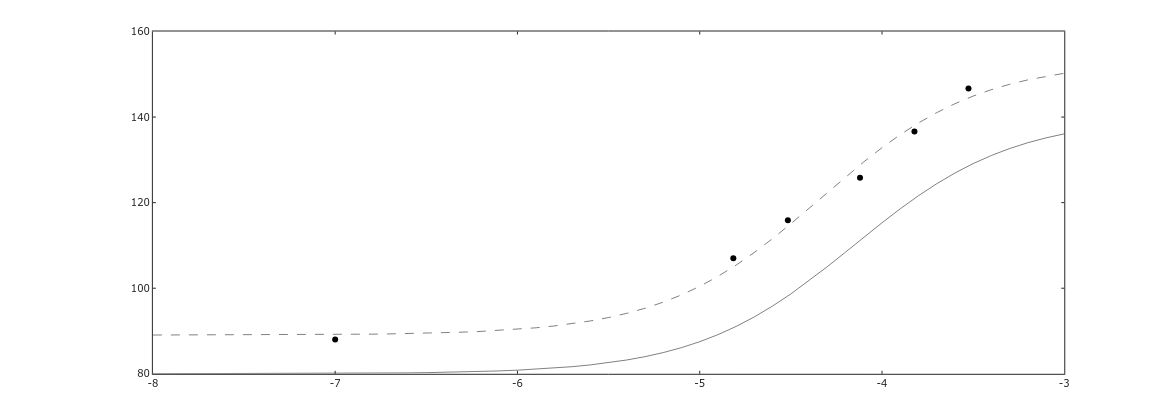

pbest,1,2,3,4
1,89.0478,153.062,-3.50839,0.148838


In [4]:
% process the data
pH=mean(originalsamplemVnpH(:,1))
mVAoriginal=(originalsamplemVnpH(:,2));
addedCuvol=data(:,1)'*1e-6;
pHcalib=data(:,3);

mVA=data(:,2)'; Emeas=mVA; CuTmeas=1e-7; CuT=CuTmeas;
CuTplus=(CuTmeas*(VT)+addedCuvol*stockCuconc)./(VT+addedCuvol);

%chlorocorrecxtion
%BF1=2.49; BF2=1.14; BF3=0.9; ClT=4.9904e-4; %from Inorg. Chem. 1983. 22. 3323-3326.
%CuTplus=CuTplus./(1+BF1*ClT+BF2*ClT^2+BF3*ClT^3);

%determine free Cu for the sample using the method of Tait et al.
m1=59.2/2; Eacid=Emeas(1); Eorig=mean(mVAoriginal); %m=param(1); 
Eo1=Eacid-(m1)*log10(CuT);
logCuonept=(Eorig-Eo1)/m1
%determine free Cu for the sample using the method of Tait et al. but use measured slope
param1=polyfit(log10(CuTplus(2:end)),Emeas(2:end),1); m2=param1(1);
Eacid=Emeas(1); Eorig=mean(mVAoriginal); 
Eo2=Eacid-(m2)*log10(CuT);
logCuoneptmeasuredslope=(Eorig-Eo2)/m2
%determine free Cu using all the calibration points
param2=polyfit(log10(CuTplus(1:end)),Emeas(1:end),1);
logCufullcalib=(mean(mVAoriginal)-param2(2))/param2(1)
%determine free Cu using high Cu additions (linear part)
param3=polyfit(log10(CuTplus(2:end)),Emeas(2:end),1);
logCulinearcalib=(mean(mVAoriginal)-param3(2))/param3(1)
%determine free Cu using two lowest points.  variable slope method like Marcinek et al.
param4=polyfit(log10(CuTplus(1:2)),Emeas(1:2),1);
logCulowslopecalib=(mean(mVAoriginal)-param4(2))/param4(1)

%use logisticmodel
logisticfunction = @(p,logx) (p(1)+(p(2)-p(1))./(1+10.^(p(3)-logx)*p(4)));
errfunction=@(p,logx,Emeas) (log10(sum((Emeas-logisticfunction(p,logx)).^2)));
ptst=[80 140 -4 0.7];
logx=-8:0.1:-3; model=logisticfunction(ptst,logx);
err=errfunction(ptst,log10(CuTplus),Emeas)
plot(log10(CuTplus),Emeas,'ko')
hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-4,'TolX',1e-4);
pbest=fminsearch(@(p) errfunction(p,log10(CuTplus),Emeas),ptst,options)
model=logisticfunction(pbest,logx);
plot(logx,model,'k--')

err = 1.8056e+00


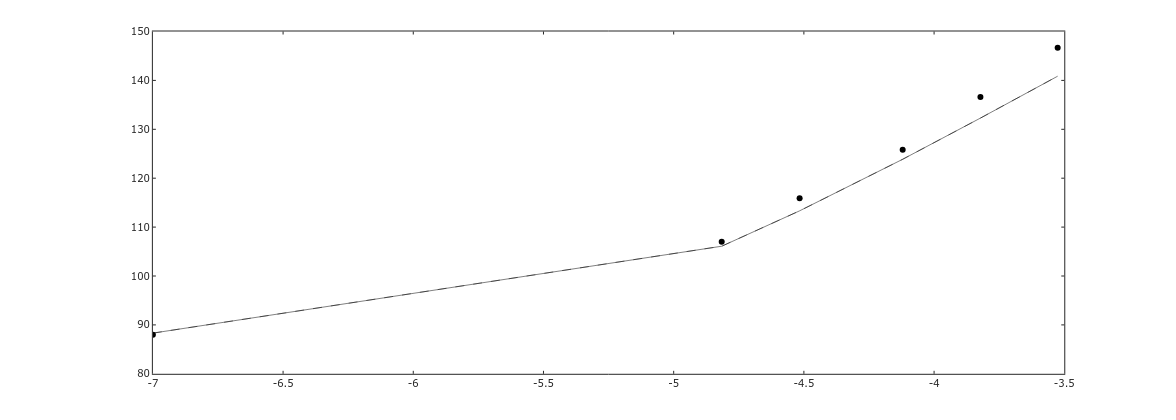

pbestNE,1,2,3
1,245.532,28.8739,0.000328929


In [5]:
% fit using Nikolskii-Eisenman equation
%E=E0+Slog(Cu +kH); parameters E0, S, k

NEeqn=@(p,x1,x2) (p(1)+p(2).*log10(x1+p(3).*x2));
errfunction=@(p,x1,x2,Emeas) (log10(sum((Emeas-NEeqn(p,x1,x2)).^2)));


H=10.^-pHcalib; ptst=[245 59.2/2 0.0005];
model=NEeqn(ptst,CuTplus',H);
err=errfunction(ptst,CuTplus',H,Emeas')

plot(log10(CuTplus), Emeas,'ko')
hold on; plot(log10(CuTplus),model,'k-')


% now best fit
pbestNE=fminsearch(@(p) errfunction(p,CuTplus',H,Emeas'),ptst,options)
NEmodel=NEeqn(pbestNE,CuTplus',H);
plot(log10(CuTplus),model,'k--')

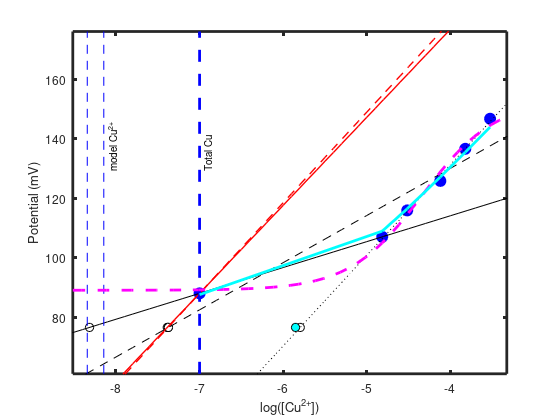

logCunonlinear = -8.7953e+00 - 9.1668e+00i


logCuNE = -5.8524e+00


In [6]:
% MODEL FOR COMPARISON
graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry

flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
database=[]; 
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=0; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

CuT=CuTmeas; inorganicTOTALS=[CuT];
inorganicTOTALS(inorganicTOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error
TOTALS=[inorganicTOTALS]; %TOTALS=inorganicTOTALS;
pH=pH; pe=20.75-pH; PCO2=10^-3.5;
[Cuall,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableauallsolids(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);
[CuwithCuOs,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableauCuOs(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);
[Cunosolid,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableaunosolid(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);

plot(log10(CuTplus),Emeas,'bo','markersize',8,'markerfacecolor','b')

hold on
possibleresults=[logCuonept logCuoneptmeasuredslope logCufullcalib logCulinearcalib logCulowslopecalib];
mVAoriginals=mean(mVAoriginal)*ones(size(possibleresults));
plot(possibleresults,mVAoriginals,'ko','markerfacecolor','w')

paramTait=[m1 Eo1];
logCuplot=-13:0.1:-3; Eplot=polyval(paramTait,logCuplot);
plot(logCuplot,Eplot,'r-','linewidth',1)

paramTait2=[m2 Eo2];
logCuplot=-13:0.1:-3; Eplot=polyval(paramTait2,logCuplot);
plot(logCuplot,Eplot,'r--','linewidth',1)

logCuplot=-13:0.1:-3; Eplot=polyval(param2,logCuplot);
plot(logCuplot,Eplot,'k--')

logCuplot=-13:0.1:-3; Eplot=polyval(param3,logCuplot);
plot(logCuplot,Eplot,'k:')

logCuplot=-13:0.1:-3; Eplot=polyval(param4,logCuplot);
plot(logCuplot,Eplot,'k-')

set(gca,'linewidth',2)
xlabel('log[Cu^{2+}]'); ylabel('E (mV)')
hold on

plot([log10(Cuall) log10(Cuall)],[min(mVAoriginal)-0.2*min(mVAoriginal) max(Emeas)+0.2*max(Emeas)],'b--')
plot([log10(Cunosolid) log10(Cunosolid)],[min(mVAoriginal)-0.2*min(mVAoriginal) max(Emeas)+0.2*max(Emeas)],'b--'); hold on
plot([log10(CuT) log10(CuT)],[min(mVAoriginal)-0.2*min(mVAoriginal) max(Emeas)+0.2*max(Emeas)],'b--','linewidth',2)
%plot([-9.576 -9.576],[-100 100],'b--')

text(log10(Cunosolid)+0.1,max(Emeas)-(max(Emeas)-mean(mVAoriginal))/4,'model Cu^{2+}','rotation',90)
text(log10(CuT)+0.1,max(Emeas)-(max(Emeas)-mean(mVAoriginal))/4,'Total Cu','rotation',90)


xlabel('log([Cu^{2+}])')
ylabel('Potential (mV)')
set(gca,'LineWidth',2,'fontsize',12)

axis([min(possibleresults)-0.2 max(log10(CuTplus))+0.2 min(mVAoriginal)-0.2*min(mVAoriginal) max(Emeas)+0.2*max(Emeas)])

% nonlinear fit
logx=min(possibleresults)-0.2:0.1:max(log10(CuTplus))+1;
model=logisticfunction(pbest,logx);
plot(logx,model,'m--','linewidth',2)

logCunonlinear=-((log10((pbest(2)-pbest(1))/(mean(mVAoriginal)-pbest(1))-1))/pbest(4)-pbest(3))

H=10.^-pH; logCuNE=log10(10.^((mean(mVAoriginal)-pbestNE(1))./pbestNE(2))-pbestNE(3)*H)

plot(logCuNE,mean(mVAoriginal),'ko','markerfacecolor','c')
plot(log10(CuTplus),NEmodel,'c-','linewidth',2)

In [7]:
disp('various calibration results')
logCuonept
logCuoneptmeasuredslope
logCufullcalib
logCulinearcalib
logCulowslopecalib
logCuNE
disp('model results')
log10(Cunosolid)
log10(Cuall)

various calibration results


logCuonept = -7.3868e+00


logCuoneptmeasuredslope = -7.3758e+00


logCufullcalib = -7.3731e+00


logCulinearcalib = -5.7959e+00


logCulowslopecalib = -8.3164e+00


logCuNE = -5.8524e+00


model results


ans = -8.1457e+00


ans = -8.3434e+00
